In [1]:
!pip install contractions rich

In [73]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analíse de reviews de videogames da Amazon

[dataset original](https://jmcauley.ucsd.edu/data/amazon/)

## Referencias
- [NLTK Book Online](http://www.nltk.org/book/)

* __Turing Talks__
    - [Introdução a NLTK com Dom Casmurro](https://medium.com/turing-talks/uma-an%C3%A1lise-de-dom-casmurro-com-nltk-343d72dd47a7)
    - [Introdução ao Processamento de Linguagem Natural com Baco Exu do Blues
](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-ao-processamento-de-linguagem-natural-com-baco-exu-do-blues-17cbb7404258)
    - [Introdução a Bag of Words e TF-IDF](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)
        - [notebook](https://github.com/turing-usp/BoW-e-TFIDF/blob/master/BoW_e_TFIDF.ipynb)
    - [Sua primeira análise de sentimentos com scikit-learn](https://medium.com/turing-talks/sua-primeira-an%C3%A1lise-de-sentimentos-com-scikit-learn-a47c088ea7bd)
        - [modelos](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos)
    - [Como Avaliar Seu Modelo de Classificação](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e)

In [161]:
from rich import print 
from rich.console import Console
from IPython.display import display, Markdown

console = Console()

In [327]:
import pandas as pd
import numpy as np
import itertools
#from pandas_profiling import ProfileReport

In [76]:
from ast import literal_eval # para representar a str '[]' como lista []
import contractions # expandir contracoes
import string # tratamentos de str
import re # remover pontucao
import unicodedata # normalizar strings

In [77]:
import nltk
from nltk.corpus import stopwords # remover stopwords
from nltk import WordNetLemmatizer, PorterStemmer # lemantizador
from nltk.probability import FreqDist # grafico com frequencia de palavras no texto
from nltk import word_tokenize, sent_tokenize # tokenizaçao
from nltk.tokenize import TweetTokenizer # tokenizaçao considerando tbm emojis e internetes
from nltk.tokenize.casual import EMOTICON_RE # remover emojis

In [78]:
#nltk.download()

In [382]:
# Features:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # TF-IDF e BoW

# Validacao:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

# Modelos:
from sklearn.ensemble import RandomForestClassifier # florestas aleatorias
from sklearn.linear_model import LogisticRegression # regressao logistica
from sklearn.tree import DecisionTreeClassifier # arvore de decisao
from sklearn.naive_bayes import MultinomialNB # naive bayes
from sklearn.svm import SVC # suport vector machine

# Metricas:
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, classification_report

# Criar pipelines para os modelos:
from sklearn.pipeline import Pipeline

In [80]:
from wordcloud import WordCloud
import cv2 as cv # Pra mascara do wordcloud

In [81]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

In [82]:
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : '16'}

mpl.rc('font', **font)

In [83]:
dfReview = pd.read_csv('video_games_reviews_train.csv')

## Pré-processamento e Análise do corpus

### Visualizacao dos dados brutos e limpeza

In [84]:
dfReview.head(10)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"
3,6070,42574,A1DP3YZ2OQWAP4,B0000ARQMW,liz,"[0, 0]",I really like this game i love all the challen...,5,Jammin banging game,1383436800,"11 3, 2013"
4,11616,172598,A48Z207T98FN0,B004HYK8Y8,The Reverend,"[296, 368]",*** please read the 12/9/11 update below this ...,1,Consumers are NOT Beta-Testers !!! (updated),1322784000,"12 2, 2011"
5,9852,214525,A0815906MFVDTIFHGRQR,B00ATF5YY8,Diego B.,"[0, 0]","At the beginning I though, &#34;Wow! this game...",3,"Ok game, kinda bad story.",1374796800,"07 26, 2013"
6,11832,62284,A1OJXGNKA0QGUW,B000B6OBPS,J. Woods,"[1, 2]","Honestly I think this is pretty bad, and let m...",1,Don't believe the hype..,1333670400,"04 6, 2012"
7,838,80635,A2SP52NH44LRDS,B000MUW98O,Happy r/c,"[0, 3]",Try GRID racing game which I think is better.W...,2,Motorcycle doing wheelie can't flip backwards,1268956800,"03 19, 2010"
8,7485,167288,A1BBYSMT9YCODI,B0045EI7I4,korova,"[60, 67]",Long time fans of Grand Theft Auto know that e...,4,Rockstar's Rashomon,1288569600,"11 1, 2010"
9,2635,207739,A2TIP4NEY64PLK,B008DNUXA8,"Fun Times Mom ""Hayley""","[7, 9]",For the few minutes that my son played he had ...,1,RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...,1355097600,"12 10, 2012"


In [85]:
dfReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         8000 non-null   int64 
 1   index           8000 non-null   int64 
 2   reviewerID      8000 non-null   object
 3   asin            8000 non-null   object
 4   reviewerName    7916 non-null   object
 5   helpful         8000 non-null   object
 6   reviewText      7999 non-null   object
 7   overall         8000 non-null   int64 
 8   summary         8000 non-null   object
 9   unixReviewTime  8000 non-null   int64 
 10  reviewTime      8000 non-null   object
dtypes: int64(4), object(7)
memory usage: 687.6+ KB


* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

Pra analises preliminares acredito que a maioria das colunas sao relevantes, com excessao de level_0, index, reviewTime (Por ser uma redundância de unixReviewTime) e reviewerName (Por ser uma redundância do reviewerID)

<span style="background-color: #ffa07a">As colunas de interesse para o modelo sao: concatenar(*reviewText* + *summary*) como X e *overall* como y</span>

Portanto esses dados nao podem conter NaN|null|None como valor ou estarem replicados, entao vou comecar por uma limpeza dessas infos

In [86]:
# Colunas com valores NaN
dfReview.isna().sum()

level_0            0
index              0
reviewerID         0
asin               0
reviewerName      84
helpful            0
reviewText         1
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Como só há 1 valor NaN na coluna *reviewText*, ao unir com a a coluna *summary* formar um unico texto, nao vao mais haver NaN, portanto nao é nescessario excluir a respectiva linha

In [87]:
# Unir as colunas reviewText e summary
dfReview['reviewText'] = dfReview.apply(lambda x: x.summary + ' ' + x.reviewText if str(x.reviewText) != 'nan' else x.summary, axis=1)

In [88]:
print("Dados duplicados " + str(len(dfReview[dfReview.duplicated()])))

Dados duplicados 0

In [89]:
print("Sobre os jogos e os avaliadores resumidamente temos:")
print('Numero de reviewerID unicos: ' + str(len(dfReview['reviewerID'].unique())) + '/' +  str(len(dfReview['reviewerID'])))
print('Numero de produtos unicos: ' + str(len(dfReview['asin'].unique())) + '/' +  str(len(dfReview['reviewerID'])))

Sobre os jogos e os avaliadores resumidamente temos:

Numero de reviewerID unicos: 6038/8000

Numero de produtos unicos: 4368/8000

In [90]:
# convertendo reviewTime em datetime:
dfReview['reviewTime'] = pd.to_datetime(dfReview['reviewTime'], format='%m %d, %Y')

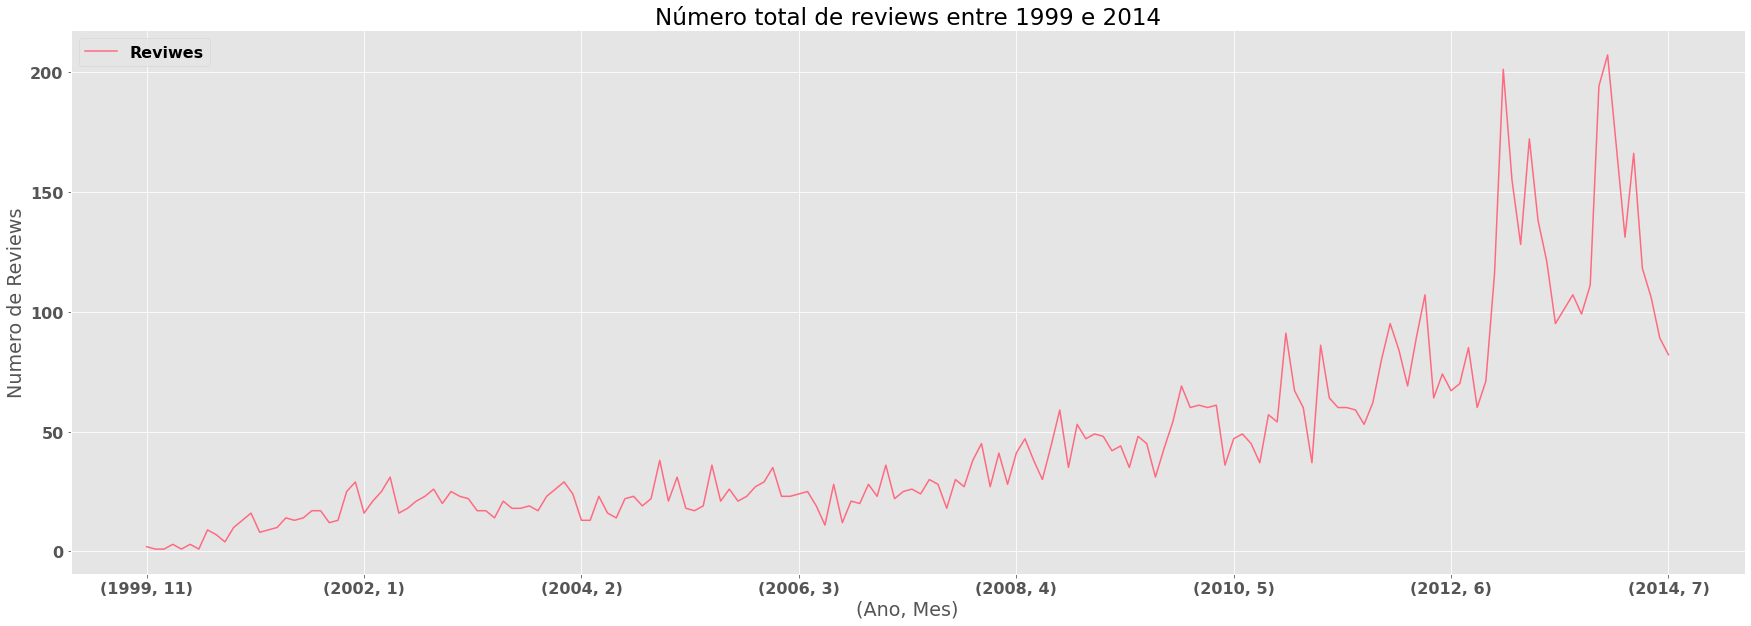

In [91]:
plt.figure(figsize=(30, 10))
p = dfReview.groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#ff6a80', label='Reviwes')
p1 = p.set_xlabel('(Ano, Mes)')
p1 = p.set_ylabel('Numero de Reviews')
p1 = p.set_title('Número total de reviews entre 1999 e 2014')
p1 = p.legend()

Da pra ver uma progressao linear do numero de reviews entre 1999 e 2014, mas não sei a principio o quanto isso é significativo, pode ser por ampliar o acesso a internet e por isso mais comentarios, mas é um palpite, ou ainda, como sao varios jogos avaliados os picos podem ser referentes ao jogo, ou mesmo combinacao desses e outros fatores. Em relacao a sazonalidade mensal não vejo nenhum padrao claro, vou ver como fica fazendo o hue entre avaliacoes positivas e negativas ao longo do tempo

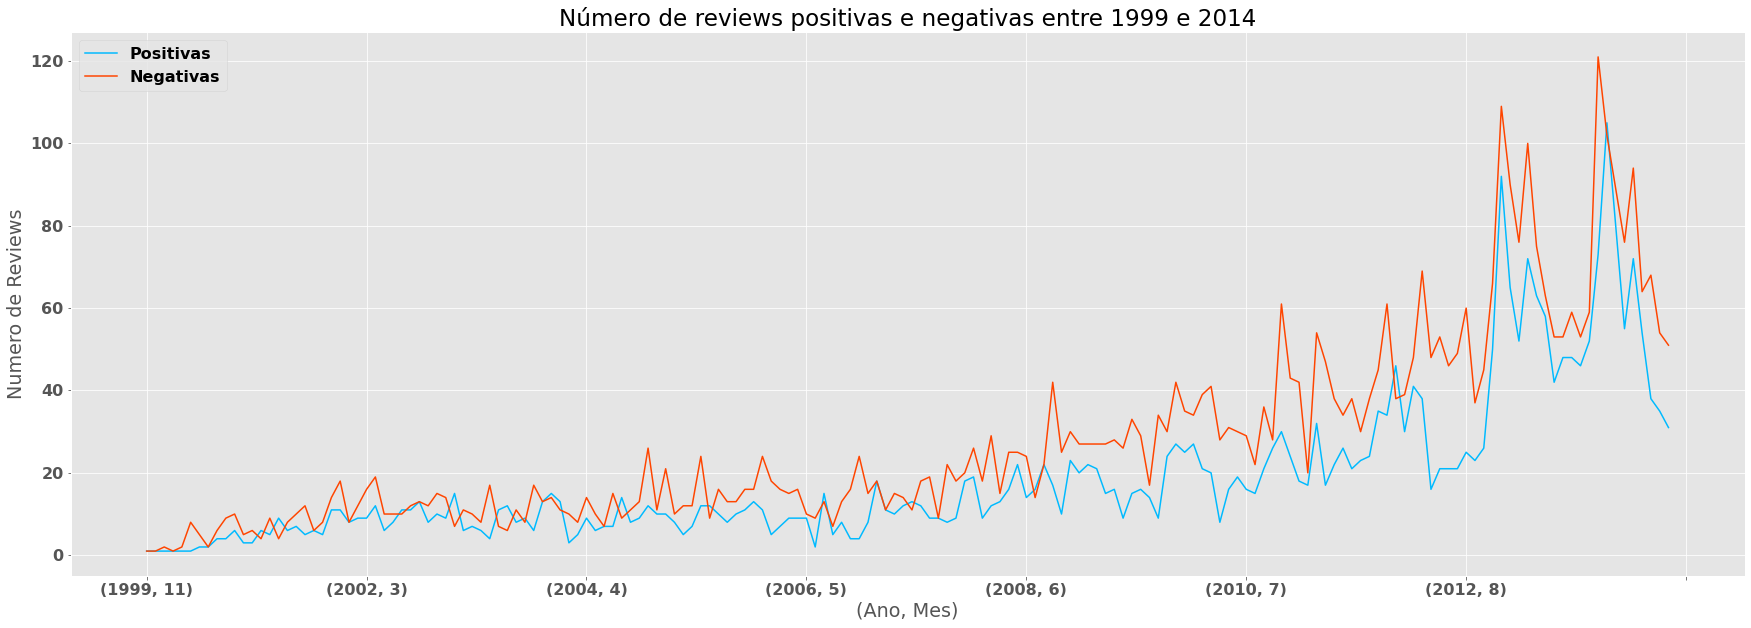

In [92]:
plt.figure(figsize=(30, 10))
p = dfReview[dfReview['overall'] > 3].groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#00baff', label='Positivas')
p1 = dfReview[dfReview['overall'] <= 3].groupby([dfReview.reviewTime.dt.year, dfReview.reviewTime.dt.month]).count()['reviewText'].plot(color='#ff4500', ax=p, label='Negativas')
p1 = p.set_xlabel('(Ano, Mes)')
p1 = p.set_ylabel('Numero de Reviews')
p1 = p.set_title('Número de reviews positivas e negativas entre 1999 e 2014')
p1 = p.legend()

Interessante muitos picos coincidirem, mas ao longo de tempo vemos tambem que o numero de reviews negativas permanece maior, vou acrescentar um pequeno filtro nisso: jogos que tenham mais que duas reviews, pois é natural se for algo que realmente nao goste, por questoes possoais, ou que tenha problema com a compra (atraso, produto errado, etc) que a pessoa deixe um comentario pontual, mas filtrando por jogos com mais que um comentario, filtramos esse viés, ou minimizamos pelo menos

In [93]:
gamesMoreOne = dfReview.groupby('asin').count()[dfReview.groupby('asin').count()['reviewText'] > 2].index
console.print(f"{len(gamesMoreOne)}/{len(dfReview)} jogos possuem mais que duas avaliacoes", style="bold", highlight=False)

768/8000 jogos possuem mais que duas avaliacoes

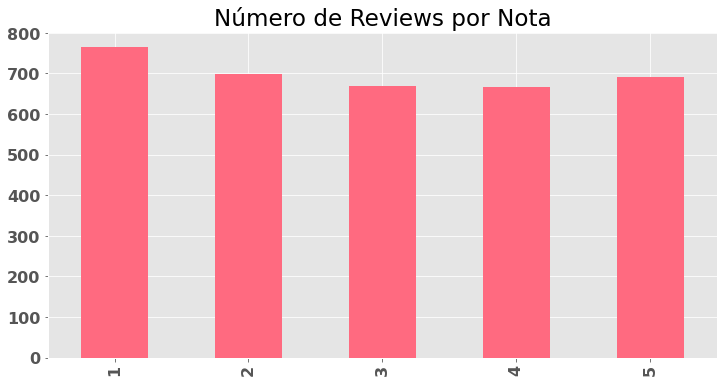

In [94]:
plt.figure(figsize=(12, 6))
p = dfReview[dfReview['asin'].isin(gamesMoreOne)]['overall'].value_counts().sort_index().plot(kind='bar', color='#ff6a80')
p1 = p.set_title('Número de Reviews por Nota')

É, o numero de reviews negativas realmente é maior ... 

Quanto a coluna *helpful* a principio vou separar em duas novas colunas *helpful_pos* e *helpful_neg*, ou seja separar em quantos consideraram a review positiva e quantos consideram negativas

In [95]:
dfReview['helpful_pos'] = dfReview['helpful'].apply(lambda x:literal_eval(x)[0])
dfReview['helpful_neg'] = dfReview['helpful'].apply(lambda x:literal_eval(x)[1]-literal_eval(x)[0])

In [96]:
dfReview[dfReview['helpful_neg'] > 1].groupby('overall').sum().reset_index()

,overall,level_0,index,unixReviewTime,helpful_pos,helpful_neg
0,1,6653153,130596376,1373721465600,13574,22567
1,2,5154073,89849915,1009518854400,7661,6162
2,3,3326439,58885631,639501177600,3834,2833
3,4,1959341,32551131,365125708800,3380,1160
4,5,1837445,31375924,329283878400,4474,1432


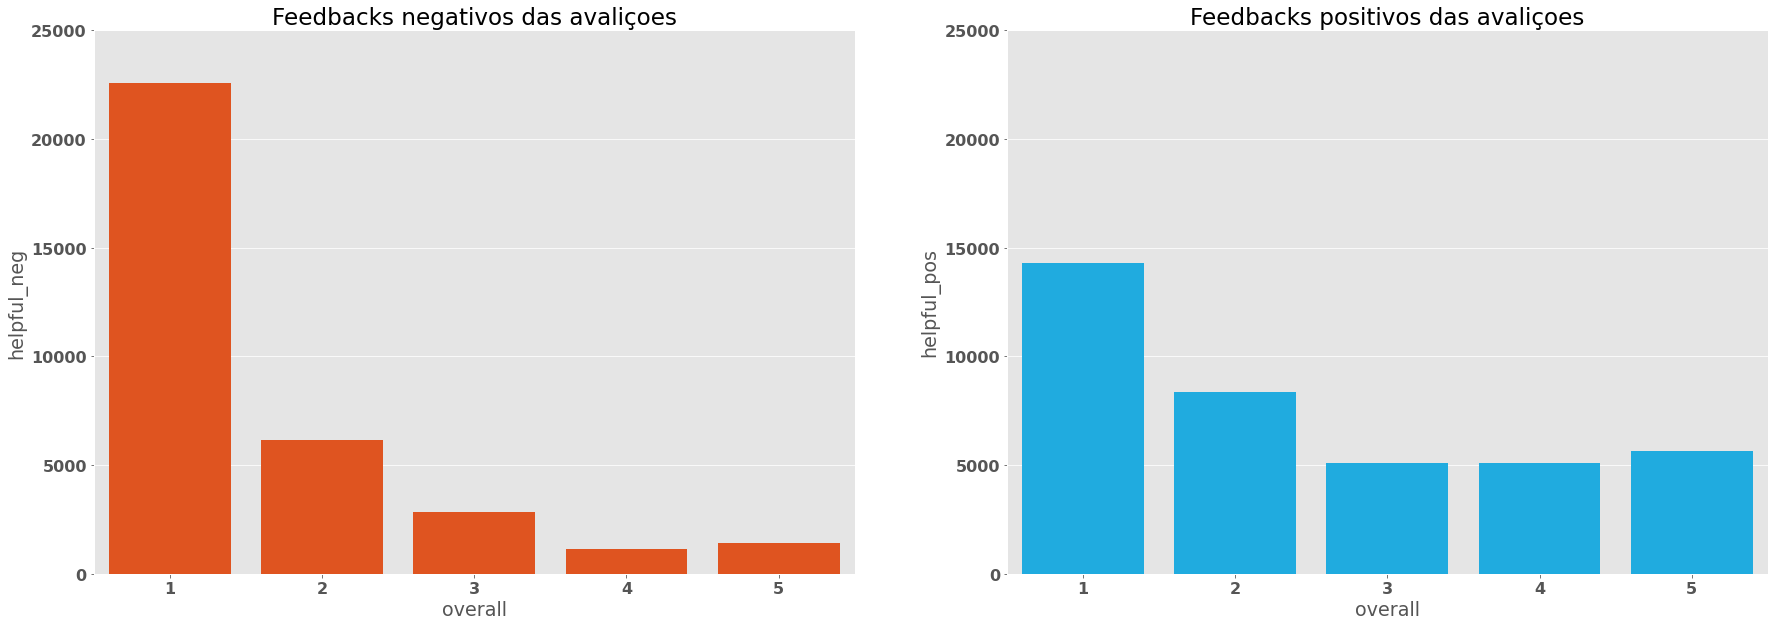

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

p = sns.barplot(data=dfReview[dfReview['helpful_neg'] > 1].groupby('overall').sum().reset_index(), 
                y='helpful_neg', 
                x='overall', color='#ff4500', ax=ax[0])

p = sns.barplot(data=dfReview[dfReview['helpful_pos'] > 1].groupby('overall').sum().reset_index(), 
                y='helpful_pos', 
                x='overall', color='#00baff', ax=ax[1])

p = ax[0].set_title('Feedbacks negativos das avaliçoes')
p = ax[1].set_title('Feedbacks positivos das avaliçoes')

p = ax[0].set_ylim(0, 25000)
p = ax[1].set_ylim(0, 25000)

Interessate, varias avaliaçoes negativas (com nota 1) receberam um feedback negativo, talvez por serem comentarios rispidos ou apenas por nao agregarem nada, como só um *Não gostei*

In [98]:
dfReview[(dfReview['overall'] == 1) & (dfReview['helpful_neg'] > dfReview['helpful_pos'])][['asin', 'reviewText']]

,asin,reviewText
0,B00CX6XKK6,wasted 500 dollars on the xbox one. ive got to...
11,B000B43OY4,Come on people! This is idiotic selling a syst...
22,B0000683EW,Very Disappointing This is the most dissapoint...
25,B000FRS9II,"don't like it I don't like the graphics, so mu..."
29,B0050SYX8W,nothing new to see here. I'll start out by say...
...,...,...
7948,B00005KBRD,This is soooo DULL! I would like to write more...
7953,B00CX9L30W,#boring going back to Rift. :( No content! Go...
7978,B0025KZV7U,bad i don't play a lot of video games but i've...
7990,B0047TLIBU,Don't Buy. Super Glitchy. Load Screens NEVER A...


Realmente ... alguns bem rispidos!

Procurei alguns desses jogos na [Amazon](https://www.amazon.com) atravez do ID (*asin*):


**B0000683EW:**
<img src="https://images-na.ssl-images-amazon.com/images/I/51HFPSGCNML.jpg" width="200" align="center">
**B000FRS9II:**
<img src="https://images-na.ssl-images-amazon.com/images/I/51cKx1N2jRL.jpg" width="200" align="center">
**B0047TLIBU:**
<img src="https://images-na.ssl-images-amazon.com/images/I/71d7GhTLvLL._SL1005_.jpg" width="200" align="center">

Eles possuem uma media de avaliaçao boa, quase 5 estrelas, talvez por isso os comentarios negativos estao mal avaliados, mas claro levando em conta que eu peguei 3 amostras em 793 reviews

Como especificado no enunciado, deve-se fazer uma classificacao binaria, **0 para avaliacao menor ou igual a 3 e 1 para maiores**, estao crio uma nova coluna binaria em funcao da *overall* mas nao faço o drop a original para algumas analises

In [99]:
# criar coluna binaria do overall 1 if nota > 3 else 0
dfReview['overallBinary'] = dfReview['overall'].apply(lambda x: 1 if x > 3 else 0)

In [100]:
neg = len(dfReview[dfReview['overallBinary'] == 0])
pos = len(dfReview[dfReview['overallBinary'] == 1])
console.print('Numeros de reviews de acordo com a polaridade: ', style="bold")
console.print('Reviews positivas: '+str(pos), style="bold #00cd37", highlight=False)
console.print('Reviews negativas: '+str(neg), style="bold #e63e00", highlight=False)

Numeros de reviews de acordo com a polaridade: 

Reviews positivas: 3238

Reviews negativas: 4762

Confirmando o grafico em função do tempo mostrando um número maior de reviews negativas.

Vou criar tambem uma coluna com o tamanho das reviws pre pre-processamento pra comparar a reducao apos remover stopwords, pontuacao, etc.

In [101]:
dfReview['lenReviewBruto'] = dfReview['reviewText'].apply(len)

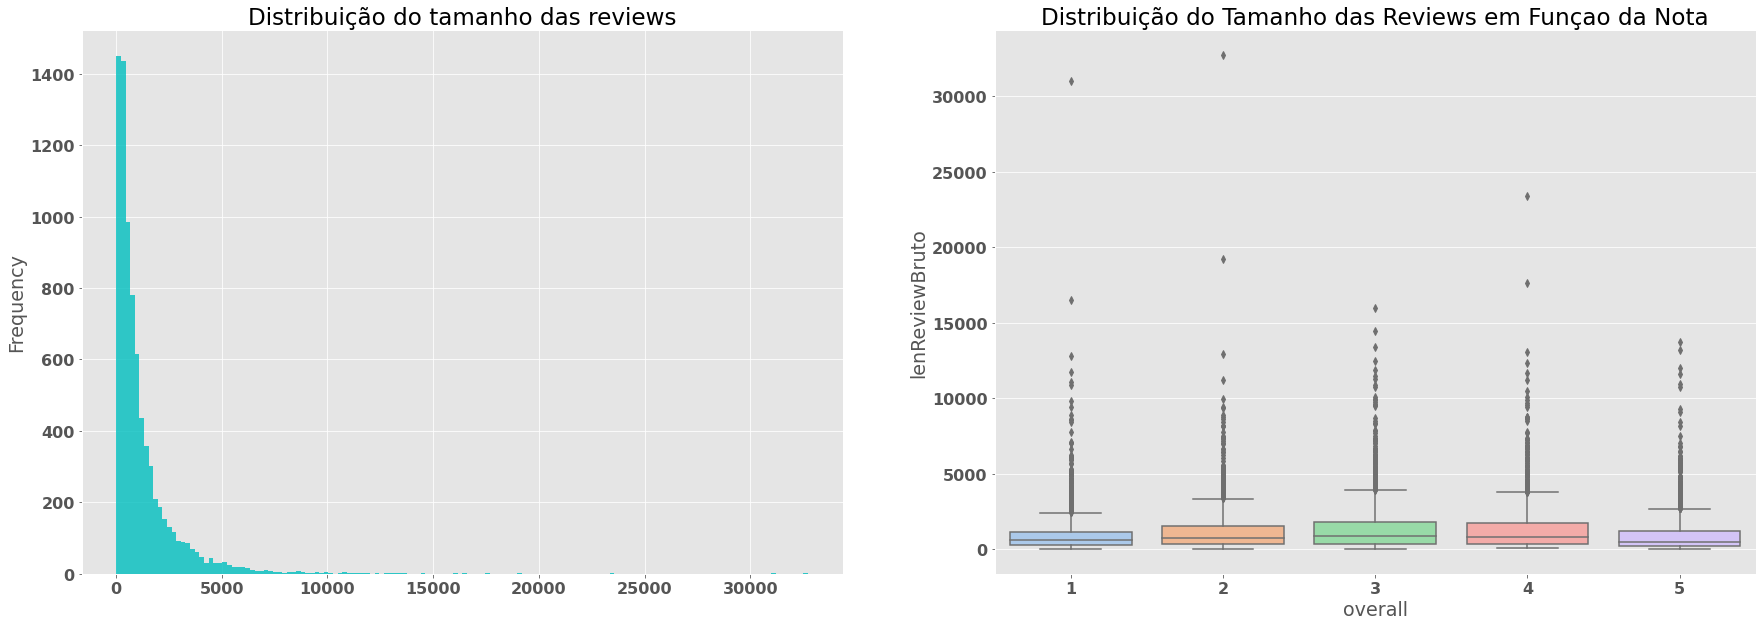

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
p = dfReview['lenReviewBruto'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='c', label='words')
p = sns.boxplot(data=dfReview, x='overall', y='lenReviewBruto', palette='pastel', ax=ax[1])
p1 = ax[0].set_title('Distribuição do tamanho das reviews')
p1 = ax[1].set_title('Distribuição do Tamanho das Reviews em Funçao da Nota')

Em relaçao a quantidade de caracteres nao parece haver correlacao direta a nota, apenas outliers discrepantes, mas a distribuicao dos dados é parececida, com volume um pouco maior para 3 e 4.

In [103]:
#df = dfReview.sort_values(by='lenReviewBruto', ascending=False).reset_index()
#df["cumpercentage"] = df["lenReviewBruto"].cumsum()/df["lenReviewBruto"].sum()*100
#
#fig, ax = plt.subplots(figsize=(30, 10))
#ax.bar(df.index, df["lenReviewBruto"], color="#ffa500")
#ax2 = ax.twinx()
#ax2.plot(df.index, df["cumpercentage"], color="#005aff")
#ax2.yaxis.set_major_formatter(PercentFormatter())
#p = ax.set_title('Distribuiçao de Pareto')

In [104]:
# removendo colunas desnecessarias:
dfReview.drop(['level_0', 'index', 'unixReviewTime', 
               'reviewerName', "summary", "helpful"], axis=1, inplace=True)

In [105]:
console.print('Dataset limpo:', style="bold #00a8e6")
#ProfileReport(dfReview.head(10))
dfReview.head(10)

Dataset limpo:

,reviewerID,asin,reviewText,overall,reviewTime,helpful_pos,helpful_neg,overallBinary,lenReviewBruto
0,A1U1AK7HKB2BLN,B00CX6XKK6,wasted 500 dollars on the xbox one. ive got to...,1,2013-11-22,4,47,0,195
1,A1L1D50VH2AX7J,B0017UFWMS,Margots Word Brain This game gives you a serie...,2,2011-11-21,0,0,0,249
2,A2JWU211CM0BYE,B00005RCR0,"Excellent product, watch the discs You should ...",4,2013-02-11,0,1,1,238
3,A1DP3YZ2OQWAP4,B0000ARQMW,Jammin banging game I really like this game i ...,5,2013-11-03,0,0,1,199
4,A48Z207T98FN0,B004HYK8Y8,Consumers are NOT Beta-Testers !!! (updated) *...,1,2011-12-02,296,72,0,5959
5,A0815906MFVDTIFHGRQR,B00ATF5YY8,"Ok game, kinda bad story. At the beginning I t...",3,2013-07-26,0,0,0,845
6,A1OJXGNKA0QGUW,B000B6OBPS,Don't believe the hype.. Honestly I think this...,1,2012-04-06,1,1,0,1029
7,A2SP52NH44LRDS,B000MUW98O,Motorcycle doing wheelie can't flip backwards ...,2,2010-03-19,0,3,0,351
8,A1BBYSMT9YCODI,B0045EI7I4,Rockstar's Rashomon Long time fans of Grand Th...,4,2010-11-01,60,7,1,3134
9,A2TIP4NEY64PLK,B008DNUXA8,RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...,1,2012-12-10,7,2,0,1063


### Pré-Processamento

#### Verificando pontuação e emojis

In [106]:
dfReview['exclamacao'] = dfReview['reviewText'].apply(lambda x:int(x.count('!')))
dfReview['interrogacao'] = dfReview['reviewText'].apply(lambda x:int(x.count('?')))
dfReview['emojis'] = dfReview['reviewText'].apply(lambda x:len(EMOTICON_RE.findall(x)))

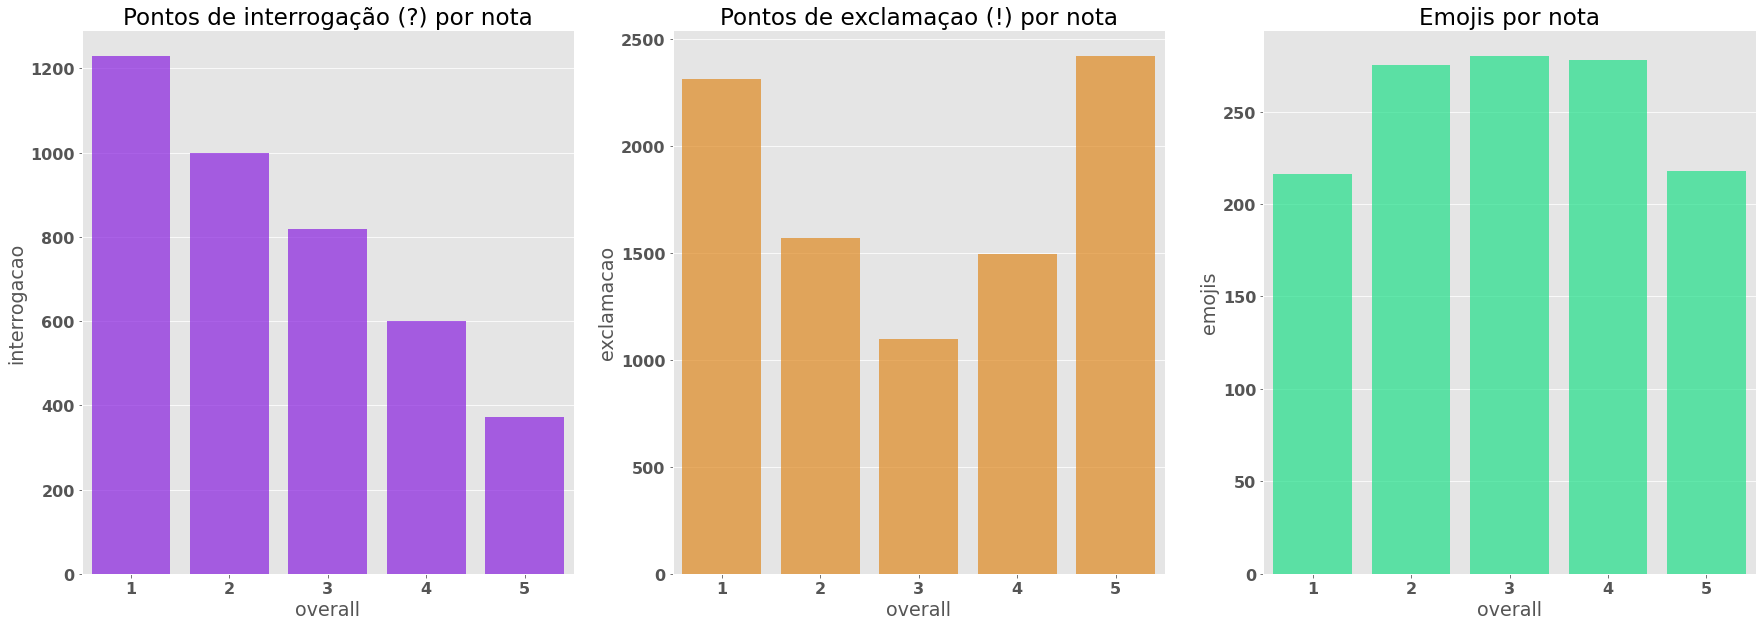

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))


p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='interrogacao', ax=ax[0], color='#8c00ff', alpha=.7)
p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='exclamacao', ax=ax[1], color='#ff8c00', alpha=.7)
p = sns.barplot(data=dfReview.groupby('overall').sum().reset_index(), x='overall', y='emojis', ax=ax[2], color='#00ff8c', alpha=.7)

p = ax[0].set_title('Pontos de interrogação (?) por nota')
p = ax[1].set_title('Pontos de exclamaçao (!) por nota')
p = ax[2].set_title('Emojis por nota')

Em relação aos emojis, pra decidir como vao ser tratados, vou ver como fica a distribuiçao deles nas reviews, criando uma lista de emojis de reviews negativas (<= 3) e positivas (>3) e depois vendo quais elementos sao unicos nessas listas, ou seja quais sao significativos para expressar a polaridade da respectiva review

In [108]:
goodReviwes = ' '.join(dfReview[dfReview['overallBinary'] == 1]['reviewText'])
badReviwes = ' '.join(dfReview[dfReview['overallBinary'] == 0]['reviewText'])

goodEmojis = EMOTICON_RE.findall(goodReviwes)
goodEmojis = list(set(goodEmojis))
badEmojis = EMOTICON_RE.findall(badReviwes)
badEmojis = list(set(badEmojis))

badUnique = [i for i in badEmojis if i not in goodEmojis]
goodUnique = [i for i in goodEmojis if i not in badEmojis]

In [109]:
console.print(f'Emojis em reviews negativas ({len(badEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(badEmojis), style="bold #ff4500", highlight=False)

console.print(f'\n\nEmojis em reviews positivas ({len(goodEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(goodEmojis), style="bold #00baff", highlight=False)

console.print(f'\n\nEmojis unicos em reviews negativas ({len(badUnique)}/{len(badEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(badUnique), style="bold #ff4500", highlight=False)

console.print(f'\n\nEmojis unicos em reviews positivas ({len(goodUnique)}/{len(goodEmojis)}): \n', style="bold", highlight=False)
console.print('   '.join(goodUnique), style="bold #00baff", highlight=False)
#ffc500

Emojis em reviews negativas (59): 

p:   ;p   /'8   8:   d:>   ]:   :o)   ;op   d=   (8   /8   8(   =(   8)   do;   |8   );   8p 
=)   do:   ;-)   :-)   p;   8/   D;   :-p   :-[   :/   :=   :D   :(   ;P   ;)   :-(   P:   =P
;d   ;:   D:   d;   d:   :-P   :P   ):   ;D   D=   =/   P;   PO:   =D   :\   :O)   :)   (=   
P8   :[   >:(   )=   ;/

Emojis em reviews positivas (55): 

p:   ;p   ]:   :-]   d=   (8   /8   8(   =(   8)   ;OP   );   )8   =)   :-)   ;-)   do:   =*[
p;   =]   =[   8/   D;   D8   d8   =p   :/   :D   P=   :(   ;P   ;)   :-(   P:   =P   ;d   ;:
D:   d;   d:   :Op   :P   ):   ;D   =/   8Op   :\   =D   :)   ::   P8   8-d   :[   :8   (:

Emojis unicos em reviews negativas (20/59): 

/'8   8:   d:>   :o)   ;op   do;   |8   8p   :-p   :-[   :=   :-P   D=   P;   PO:   :O)   (= 
>:(   )=   ;/

Emojis unicos em reviews positivas (16/55): 

:-]   ;OP   )8   =*[   =]   =[   D8   d8   =p   P=   :Op   8Op   ::   8-d   :8   (:

<span style="background-color: #ffbf00">Por mais que hajam relativamente muitos emojis aparentemente eles nao agregam muito ao resultado da polaridade pois ha muitos emojis do tipo :-) em reviews negativas e :-( em positivas e numero unico por polaridade é bem baixo em proporção, entao eu vou remove-los junto com as stopwords</span>(tratadas a seguir)

#### Remocao de stopwords

A principio, estou usando a lista de stopwords da biblioteca nltk, que contem as seguintes palavras: 

In [110]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Mas fazendo apenas isso uma primeira vez obtive o seguinte: 

<span style="background-color: #ffa07a">Frequencia das palavras no geral: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq.jpg)

<span style="background-color: #ffa07a">Frequencia das palavras em reviews positivas: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq_pos.png)

<span style="background-color: #ffa07a">Frequencia das palavras em reviews negativas: </span>
![resultado da primera tentativa de remocao de stopwords](imagens/word_freq_neg.png)

Há muitas palavras que aparentemente nao agragam muito a polaridade da review no contexto compra de jogos e nao estao na lista de nltk, como: **game**, **buy** e **play** e outras que se repetem muito, sem ter relacao direta com o contexto, mas tambem não parecem agregar muito, como: **like**, **get** e **one**

E a concordancia e pavras similares a elas eram:

In [168]:
with open('imagens/concordancias_similaridades.txt', 'r') as textfile:
    print(textfile.read())

Concordancia para palavra play: 
Displaying 25 of 10848 matches:
waste dollars xbox one get play console honestly say look x better p
ccasional game simply miss boat come play fun excellent product watch discs pr
ay bethesdas payroll would like able play game instead feel like get rob lie u
econd time row hoop ask players jump play mess balance basketball nose play he
mp play mess balance basketball nose play help end update ok game kind bad sto
o change parametershowever opponents play way matter even change strength hand
nd total opposites default opponents play way think change anything effecti te
opponent full table various settings play hours still play play alter themit o
le various settings play hours still play play alter themit ok simulator play 
rious settings play hours still play play alter themit ok simulator play somew
 play play alter themit ok simulator play somewhat competent opponents style t
tion whether gta iv two episodes fun play answer yes even though clear rocksta
e price set big deal important thing play series order release gta iv tlad tbo
keep year olds attention minutes son play jump around maze platforms kill bug 
me kill bug jump around figure maybe play minutes topsand want buy game thank 
buy game read review get game excite play replay quickly subside get think bac
partcroft manor back see change love play section nice little distractionwith 
ay level remove force start new game play againthe bonoculars although cool us
lax game need take seriously already play game think already play game back ca
usly already play game think already play game back call call duty stop play o
y play game back call call duty stop play overwhelm sense know war suppose cha
ntertain get thru cod desire go back play yet play game different name slight 
get thru cod desire go back play yet play game different name slight change sc
k xiii control like console fps game play socom red faction timesplitters fami
 old kid wrong p bore think remember play first come playstation think remembe

Palavras similares a play: 
game get like make one buy fun good great go really first time think
say would look use see even



Concordancia para palavra like: 
Displaying 25 of 8977 matches:
stroy errors jammin bang game really like game love challenge love different p
e charge pay bethesdas payroll would like able play game instead feel like get
uld like able play game instead feel like get rob lie update patch issue repor
bad story begin though wow game look like really cool timeline split story sto
remise game completely awesome least like time travel stuff however narrative 
ke much expensive mistake still sort like would bet one come price rather quic
ven enjoy slower pace game sometimes like deblob game near captivate buy donke
 game near captivate buy donkey kong like jump around squash things much bette
little distractionwith onto badwhile like croft manor inability replay level r
level begin show terrible werei felt like game nothing assault course lara go 
r insult injury level far short come like explore every nook cranny every leve
e first conquer puzzle get main boss like anniversarylara look great wear fall
sult injury show cleavage doube uggh like women much beutiful woman dress like
like women much beutiful woman dress like esepcially archeologist hate despise
i game within main gamethe one thing like game move forward onto different pla
g graphical technique make game look like cartoon level detail throughout amaz
el detail throughout amaze look feel like comic book xiii control like console
ok feel like comic book xiii control like console fps game play socom red fact
rsion exclusive multiplayer mode fun like deathmatch kill certain players xbox
nce pay may keep sexappeal also lack like slutty teenager game try hard get ex
irst come playstation think remember like somewhatbut boy wrong change quite l
on perspective work well shootthemup like graphics game concept control paramo
eview k cut many options play online li

Ja existem outras palavras similares que nao parecem muito, <span style="background-color: #ffbf00">entao decidi tirar essa primeras palavras junto com as stopwords com execassao do like que pode ser uma polissemia</span>. Mesmo havendo maios palavras assim acho que nao seria interessante remover todas pois acredito que possa causar um overfitting do modelo

In [169]:
# texto = nltk.Text(' '.join(list(dfReview['reviewTextPreProc'])).split())

# console.print('Concordancia para palavra play: ', style="bold", highlight=False)
# display(Markdown(texto.concordance('play')))
# console.print('Palavras similares a play: ', style="bold", highlight=False)
# texto.similar('play')

# console.print('\n\n\n\nConcordancia para palavra like: ', style="bold", highlight=False)
# print(texto.concordance('like'))
# console.print('Palavras similares a like: ', style="bold", highlight=False)
# texto.similar('like')

# console.print('\n\n\n\nConcordancia para palavra one: ', style="bold", highlight=False)
# print(texto.concordance('one'))
# console.print('Palavras similares a one: ', style="bold", highlight=False)
# texto.similar('one')

# console.print('\n\n\n\nConcordancia para palavra time: ', style="bold", highlight=False)
# print(texto.concordance('time'))
# console.print('Palavras similares a time: ', style="bold", highlight=False)
# texto.similar('time')

# console.print('\n\n\n\nConcordancia para palavra buy: ', style="bold", highlight=False)
# print(texto.concordance('buy'))
# console.print('Palavras similares a buy: ', style="bold", highlight=False)
# texto.similar('buy')

# console.print('\n\n\n\nConcordancia para palavra get: ', style="bold", highlight=False)
# print(texto.concordance('get'))
# console.print('Palavras similares a get: ', style="bold", highlight=False)
# texto.similar('get')

# console.print('\n\n\n\nConcordancia para palavra game: ', style="bold", highlight=False)
# print(texto.concordance('game'))
# console.print('Palavras similares a game: ', style="bold", highlight=False)
# texto.similar('game')

In [231]:
def Preprocessamento(texto):
    texto = texto.lower()
    
    # remocao de contracoes
    texto = contractions.fix(texto)
    
    texto = texto.lower()
    
    # remocao de pontuacao
    pontuacao = re.compile('|'.join(map(re.escape, string.punctuation+'1234567890')))
    texto = pontuacao.sub("", texto)
    
    # vetorizacao
    tk = TweetTokenizer()
    texto = tk.tokenize(texto)
    
    # normalizar
    for i, palavra in enumerate(texto):
        texto[i] = unicodedata.normalize('NFKD', palavra).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        
    # lemmantizacao
    lemmantizador = nltk.WordNetLemmatizer()
    tokentxt =  [lemmantizador.lemmatize(palavra, pos='v') for palavra in texto]
    
    # remocao de stopwords
    cleanTexto = []
    StopWords = stopwords.words('english')
    
    StopWords.append('game')
    StopWords.append('play')
    StopWords.append('one')
    StopWords.append('get')
    StopWords.append('make')
    StopWords.append('buy')
    StopWords.append('time')
    StopWords.append('character')
    
    for palavra in tokentxt:
        if palavra not in StopWords: cleanTexto.append(palavra)
        else: pass
        
    # removendo verbos
    #tokentxt = nltk.pos_tag(cleanTexto)
    #texto = []
    #for i, palavra in enumerate(tokentxt):
    #    if palavra[1] not in  ['VB', 'PRP']:
    #       texto.append(palavra[0])
        
    return ' '.join(cleanTexto)

In [232]:
%%time
dfReview['reviewTextPreProc'] = dfReview['reviewText'].apply(Preprocessamento)

CPU times: user 13.2 s, sys: 75.9 ms, total: 13.2 s
Wall time: 13.2 s


In [233]:
print('[bold #ffa64d]Antes do Preprocessamento():[/bold #ffa64d]')
print()
display(dfReview['reviewText'].head(20))
print('\n\n[bold #ffa64d]Depois do Preprocessamento():[/bold #ffa64d]')
print()
display(dfReview['reviewTextPreProc'].head(20))

Antes do Preprocessamento():

0     wasted 500 dollars on the xbox one. ive got to...
1     Margots Word Brain This game gives you a serie...
2     Excellent product, watch the discs You should ...
3     Jammin banging game I really like this game i ...
4     Consumers are NOT Beta-Testers !!! (updated) *...
5     Ok game, kinda bad story. At the beginning I t...
6     Don't believe the hype.. Honestly I think this...
7     Motorcycle doing wheelie can't flip backwards ...
8     Rockstar's Rashomon Long time fans of Grand Th...
9     RENT THIS ONE!!! IT COULDN'T KEEP A 6 YEAR OLD...
10    returned was Christmas gift but poor as had no...
11    Come on people! This is idiotic selling a syst...
12    TombRaider: Legend Don't buy this game! Why? R...
13    At Least It Comes with a Controller The game i...
14    Fun yet challenging Unlike many game sequels, ...
15    Haven't I already played this game? I think I ...
16    A beautiful, challenging FPS. XIII is a beauti...
17    Great next gen start I bought my x1 from w

Depois do Preprocessamento():

0     waste dollars xbox console honestly say look x...
1     margots word brain give series word puzzle fig...
2     excellent product watch discs pretty much alre...
3     jammin bang really like love challenge love di...
4     consumers betatesters update please read updat...
5     ok kind bad story begin though wow look like r...
6     believe hype honestly think pretty bad let exp...
7     motorcycle wheelie flip backwards try grid rac...
8     rockstars rashomon long fan grand theft auto k...
9     rent could keep year olds attention minutes so...
10    return christmas gift poor nothing go soon kin...
11    come people idiotic sell system high price sel...
12    tombraider legend read review excite replay qu...
13    least come controller average fun days mainly ...
14    fun yet challenge unlike many sequels improve ...
15    already think already back call call duty stop...
16    beautiful challenge fps xiii beautiful challen...
17    great next gen start x walmart system grea

In [234]:
#dfReview['reviewTextPreProc'].loc[1]

### Analises

#### Frequencia de palavras

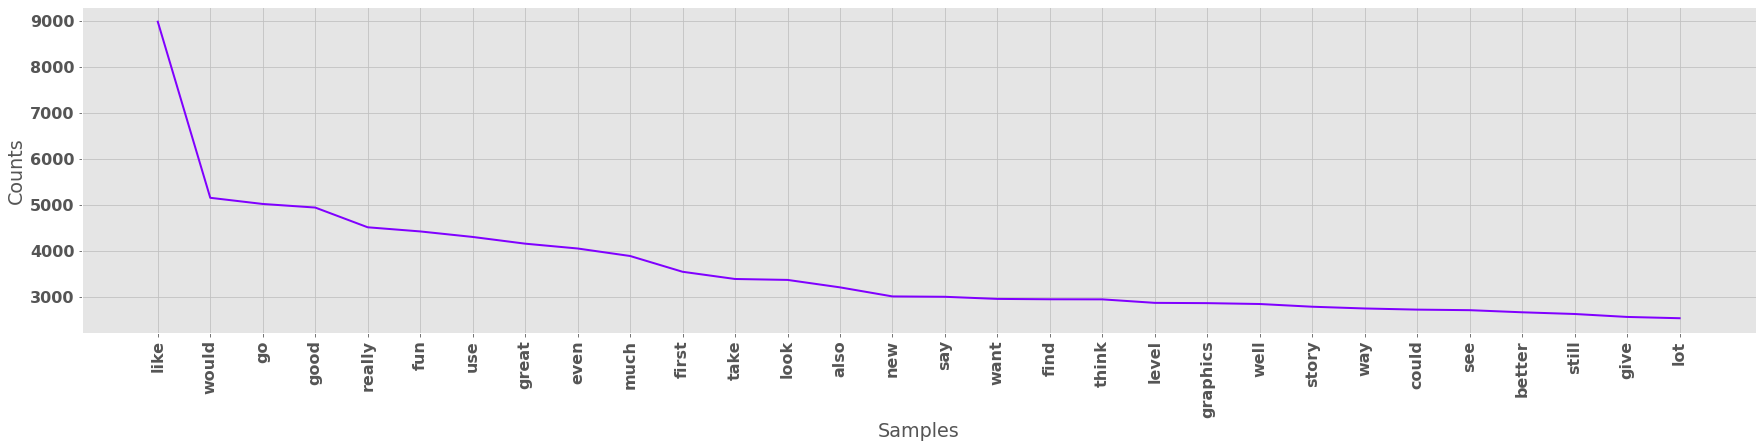

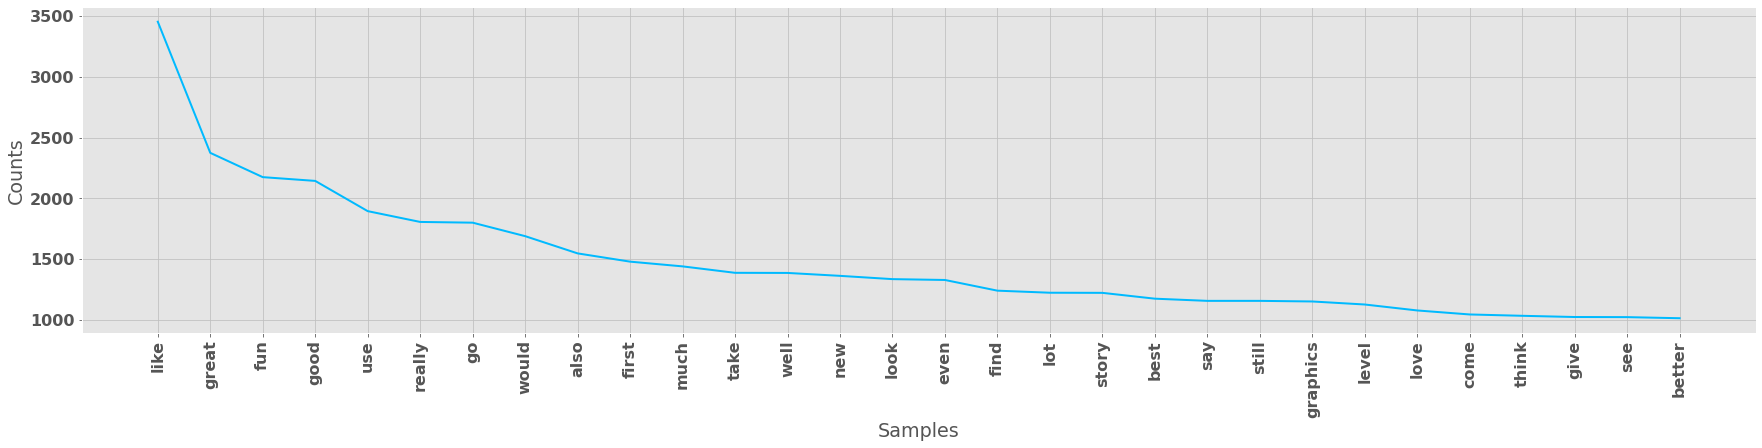

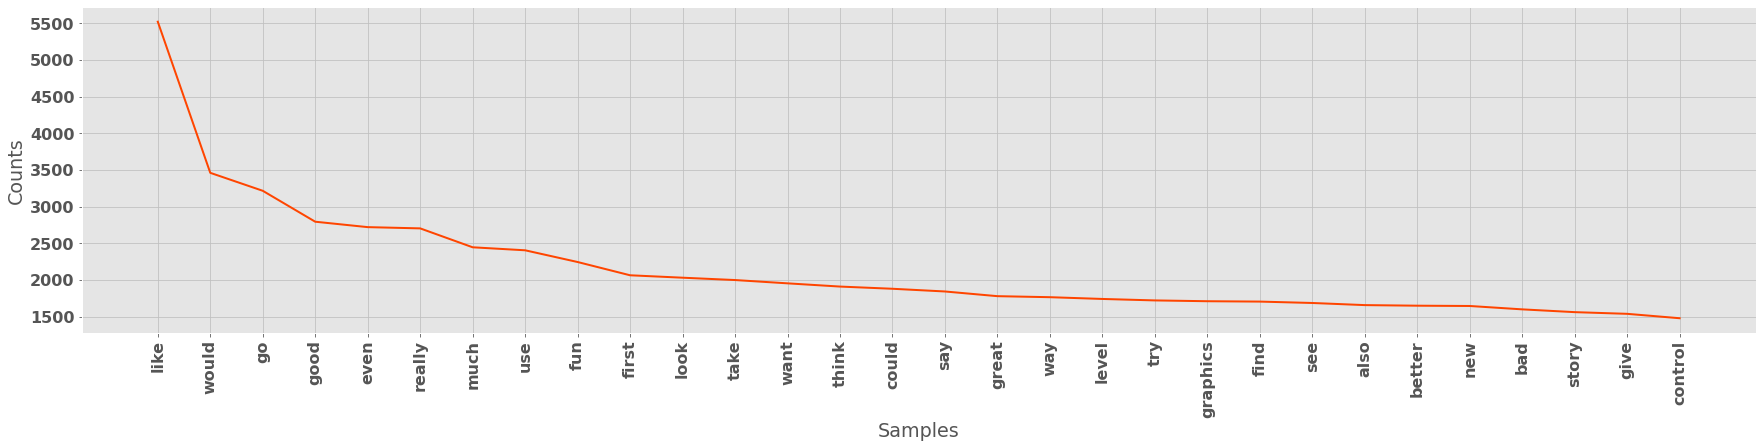

In [235]:
#fig, ax = plt.subplots(3, 1, figsize=(15, 20))

wtk = word_tokenize(' '.join(dfReview['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#8000ff')
#p.set_title('Frequencia de palavras no geral')

wtk = word_tokenize(' '.join(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#00baff')
#p.set_title('Frequencia de palavras em reviews positivas')

wtk = word_tokenize(' '.join(dfReview[dfReview['overallBinary'] == 0]['reviewTextPreProc']))
freq = FreqDist(wtk)
plt.figure(figsize=(30,6))
p = freq.plot(30, color='#ff4500', )
#p.set_title('Frequencia de palavras em reviews negativas')

In [236]:
ret, mask = cv.threshold(cv.imread('imagens/controller.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

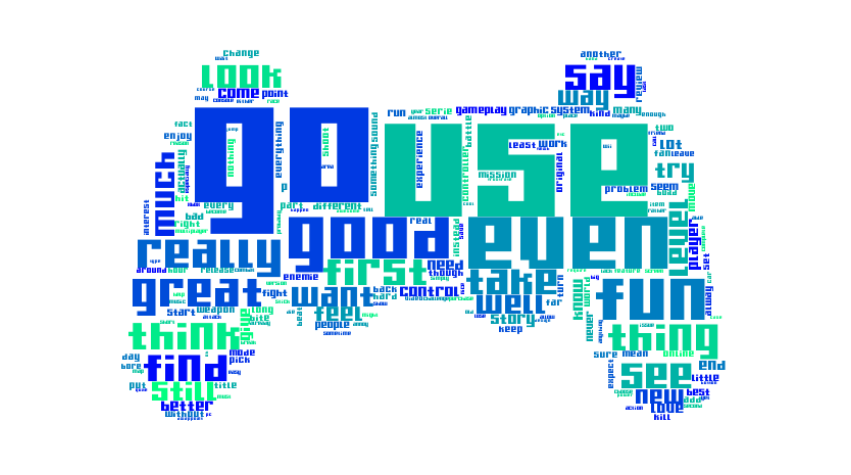

In [237]:
text = ' '.join(list(dfReview['reviewTextPreProc']))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=mask, 
                      font_path='Gamer.ttf',
                      colormap="winter",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")

In [238]:
ret, maskP = cv.threshold(cv.imread('imagens/pos.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

ret, maskN = cv.threshold(cv.imread('imagens/neg1.png'),
                         55,
                         255,
                         cv.THRESH_BINARY)

(-0.5, 899.5, 599.5, -0.5)

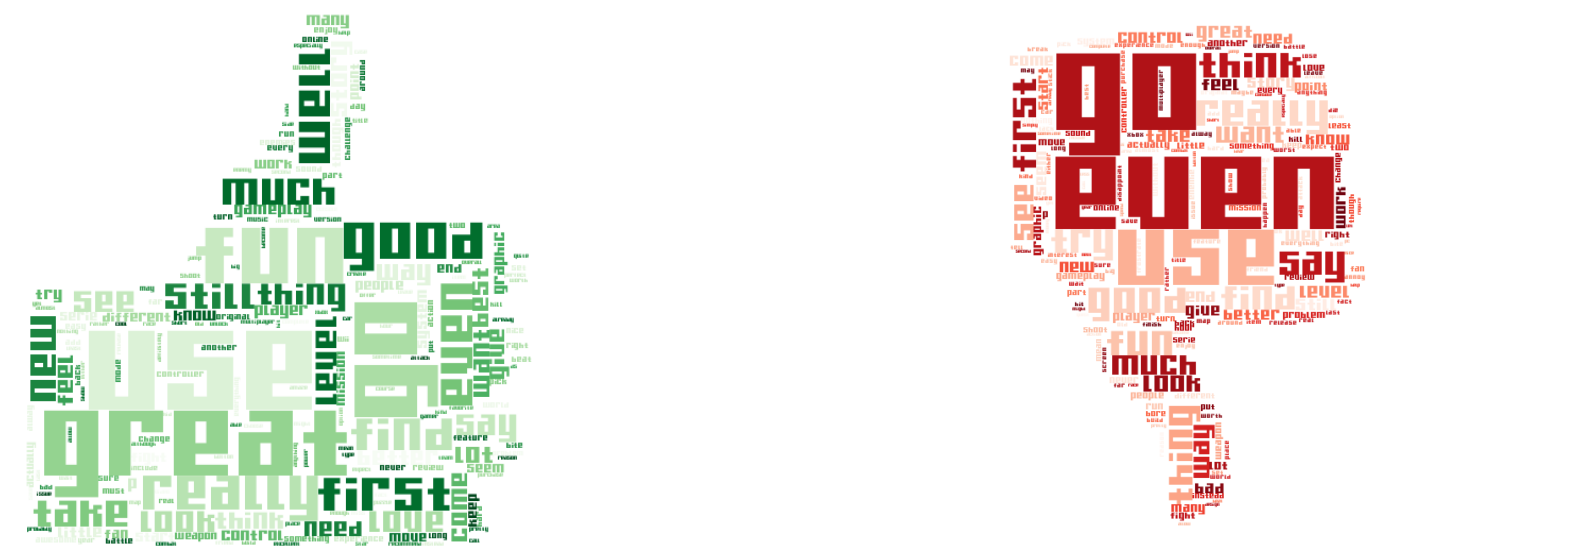

In [239]:
text = ' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc']))

wordcloudP = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskP, 
                      font_path='Gamer.ttf',
                      colormap="Greens",).generate(text)

text = ' '.join(list(dfReview[dfReview['overallBinary'] == 0]['reviewTextPreProc']))

wordcloudN = WordCloud(background_color="white",
                      width=500, height=500,
                      mask=maskN, 
                      font_path='Gamer.ttf',
                      colormap="Reds",).generate(text)

fig, ax = plt.subplots(1, 2, figsize=(30,10))
ax[0].imshow(wordcloudP, interpolation='bilinear')
ax[1].imshow(wordcloudN, interpolation='bilinear')

ax[0].axis("off")
ax[1].axis("off")

#### Revendo o tamanho das reviews apos o preprocessamento

In [240]:
dfReview['lenReviewPreProc'] = dfReview['reviewTextPreProc'].apply(len)

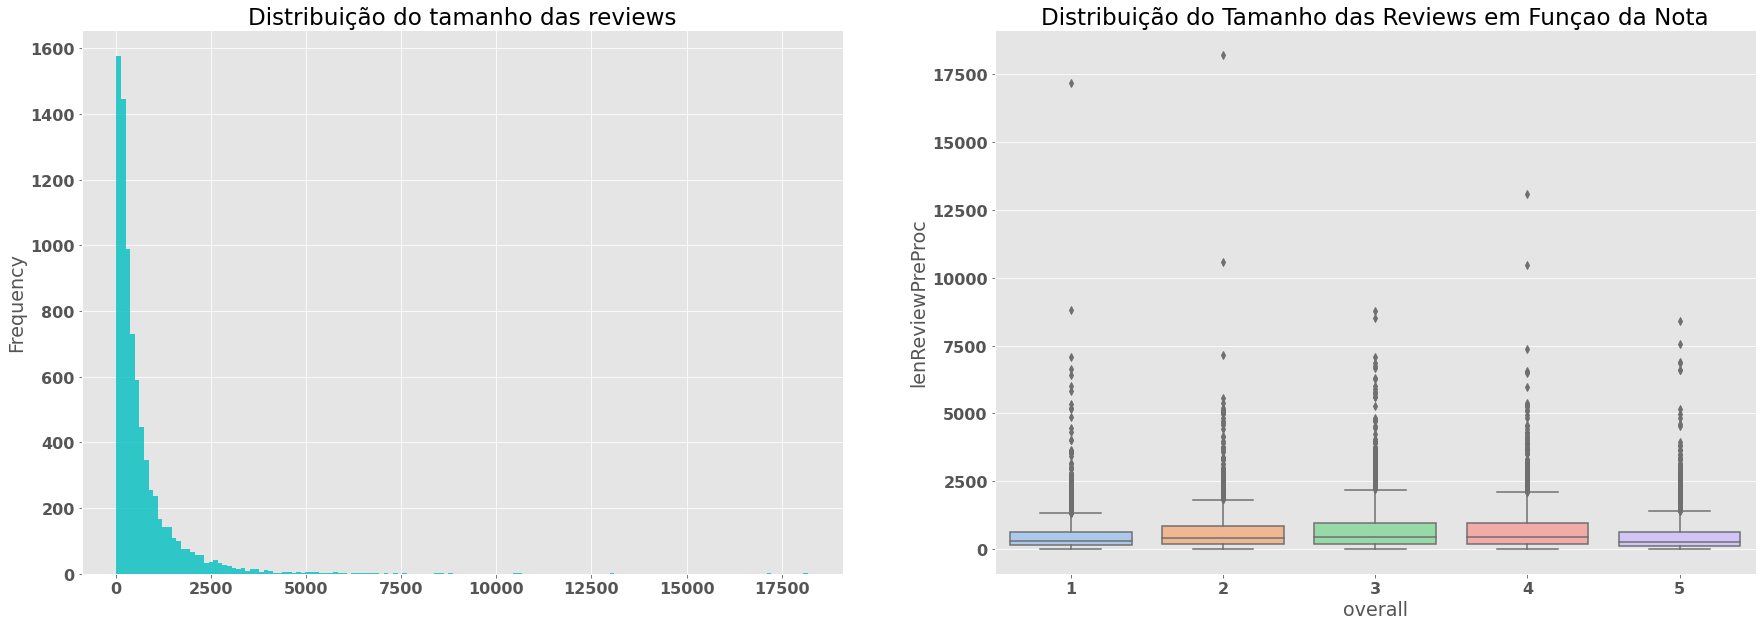

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
p = dfReview['lenReviewPreProc'].plot(kind='hist', bins=150, ax=ax[0], alpha=.8, color='c', label='words')
p = sns.boxplot(data=dfReview, x='overall', y='lenReviewPreProc', palette='pastel', ax=ax[1])
p1 = ax[0].set_title('Distribuição do tamanho das reviews')
p1 = ax[1].set_title('Distribuição do Tamanho das Reviews em Funçao da Nota')

A distribuicao nao mudou muito

#### Classes gramaticais presentes

In [292]:
text = word_tokenize(' '.join(list(dfReview[dfReview['overallBinary'] == 1]['reviewTextPreProc'])))
tags = nltk.pos_tag(text)

grammar_classes = []

for tag in tags:
    grammar_classes.append(tag[1])

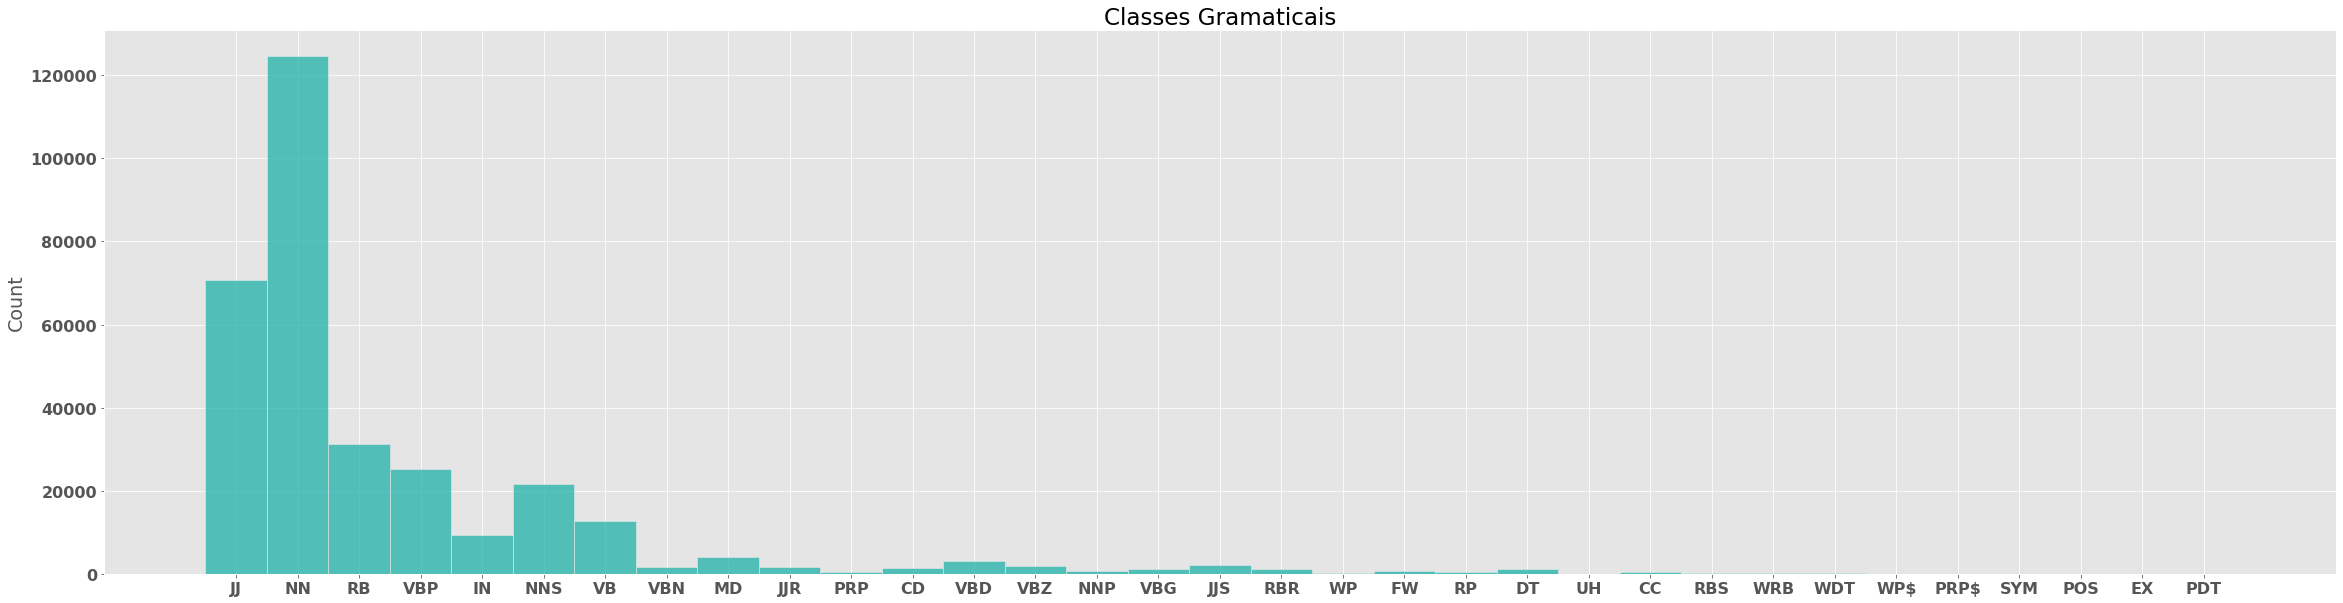

In [300]:
plt.figure(figsize=(40,10))
g = sns.histplot(grammar_classes, color='#20b2aa')
p = g.set_title('Classes Gramaticais')

A classes que mais aparecem são **substantivos (NN)**, **Adjectives (JJ)** e **Advérbios (RB)** respectivamente. O dicionario completo tem [nesse link](https://sites.google.com/site/partofspeechhelp/)

## Modelagem

### TF-IDF

In [243]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(dfReview['reviewTextPreProc'])

In [244]:
print(X_tfidf)

(0, 24218)    0.22012037545035615
  (0, 27293)    0.3147237900766817
  (0, 26835)    0.24151448382205665
  (0, 35003)    0.4175265880699754
  (0, 4308)     0.16357987157830842
  (0, 25818)    0.15547383264208633
  (0, 38666)    0.15991101962574866
  (0, 21018)    0.30435039174936784
  (0, 8620)     0.24915149141087425
  (0, 50453)    0.46060287779364534
  (0, 12019)    0.334154527606381
  (0, 48877)    0.25459055644022527
  (1, 17018)    0.09491347892132854
  (1, 8032)     0.11336700587017066
  (1, 4878)     0.2804803936804828
  (1, 27809)    0.1708669927949179
  (1, 40406)    0.16836362802198304
  (1, 30511)    0.2654725782120725
  (1, 15810)    0.1833997672724489
  (1, 8236)     0.25725917916313307
  (1, 38944)    0.38746746097489143
  (1, 15126)    0.13302664134820755
  (1, 15740)    0.17685618504478298
  (1, 35276)    0.18463069013208291
  (1, 39481)    0.14459257509904683
  :     :
  (7999, 15798) 0.041862096707823385
  (7999, 8195)  0.06572010405321994
  (7999, 24780) 0.06791405677130855
  (7999, 49252) 0.04041964332794538
  (7999, 25911) 0.04299709003518874
  (7999, 46386) 0.0424248047234869
  (7999, 24269) 0.05657446992977641
  (7999, 18578) 0.034407834373903316
  (7999, 40030) 0.11291782258396768
  (7999, 23229) 0.27239632352642823
  (7999, 26500) 0.08889634486017908
  (7999, 12488) 0.06680226445313898
  (7999, 42242) 0.04690816175074006
  (7999, 24067) 0.050346562820652155
  (7999, 31737) 0.05775178182073119
  (7999, 19018) 0.03870205329056549
  (7999, 25567) 0.04488888075934395
  (7999, 17574) 0.04688230774768252
  (7999, 15931) 0.03883658748579461
  (7999, 11288) 0.048811757534035105
  (7999, 47691) 0.03751601199575914
  (7999, 37500) 0.049937665858169465
  (7999, 17018) 0.06977821032171488
  (7999, 15810) 0.06741564885793448
  (7999, 18452) 0.0417007246912514

In [280]:
tfidf_vocabulario = dict(zip(list(tfidf_vect.vocabulary_.values()), list(tfidf_vect.vocabulary_.keys())))

In [277]:
vocabulario_txt = []
vocabulario_values= []

for j, i in enumerate(X_tfidf.indices):
    vocabulario_txt.append(tfidf_vocabulario[i])
    vocabulario_values.append(X_tfidf.data[j])

In [279]:
vocabulario = dict(zip(vocabulario_txt, vocabulario_values))
vocabulario

{'kill': 0.03914867078246667,
 'mess': 0.05001862610788188,
 'maybe': 0.09447552701357861,
 'ps': 0.0442129906929906,
 'better': 0.03174016622526133,
 'look': 0.04941849170403782,
 'say': 0.033866798543784916,
 'honestly': 0.060776309707216154,
 'console': 0.08862377862338965,
 'xbox': 0.04091454504335061,
 'dollars': 0.1252731264446717,
 'waste': 0.09028113400137094,
 'fun': 0.06977821032171488,
 'come': 0.026524347506669765,
 'boat': 0.03907650307194688,
 'miss': 0.05012151101675096,
 'simply': 0.049495370970363405,
 'occasional': 0.05823029294471724,
 'fine': 0.06741564885793448,
 'compete': 0.15661037032098915,
 'scrabble': 0.3491464913776269,
 'fan': 0.05699871511424295,
 'figure': 0.10184793819342894,
 'puzzle': 0.09176625394946501,
 'series': 0.03781663778395903,
 'give': 0.0417007246912514,
 'brain': 0.1464639513458676,
 'word': 0.05689641603998052,
 'margots': 0.4186930302037677,
 'errors': 0.14496990242894855,
 'destroy': 0.029615203167165333,
 'riddle': 0.06777445784242826,


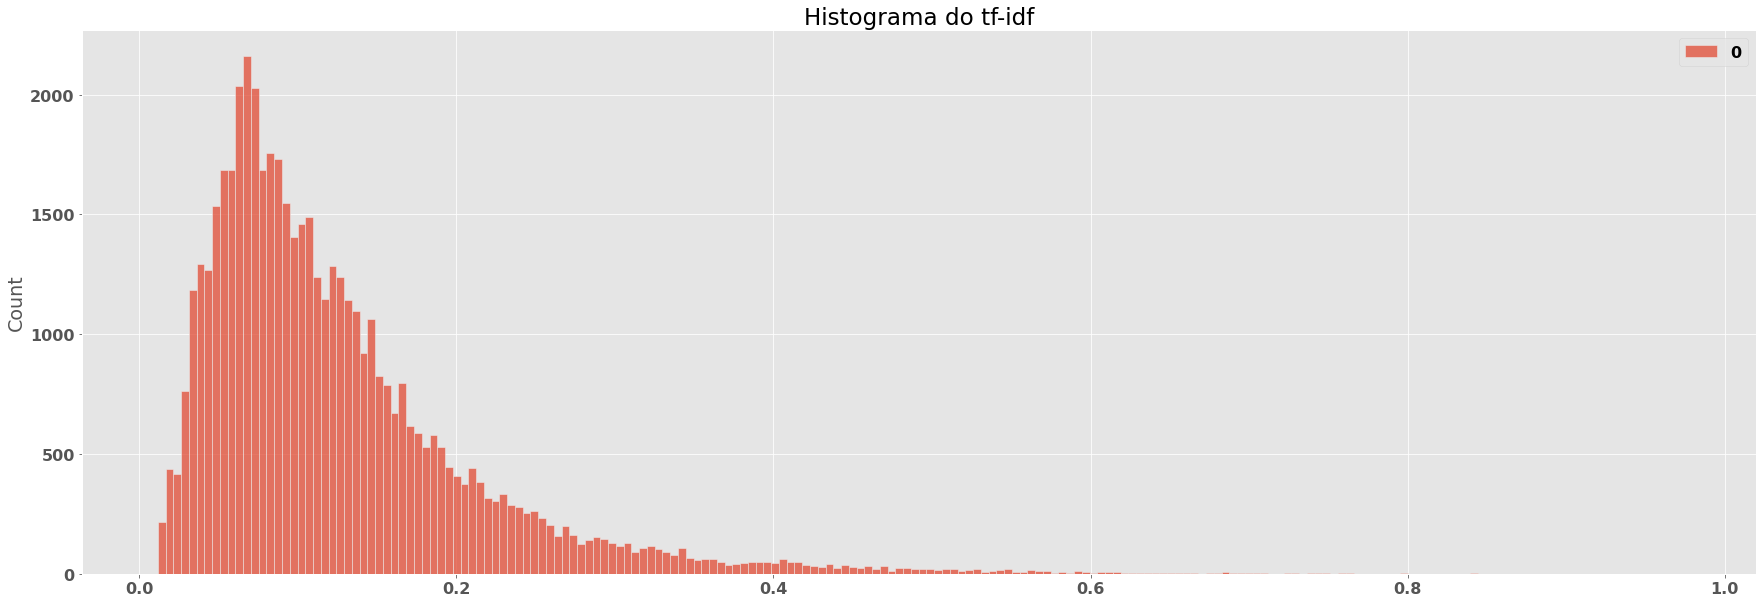

In [301]:
plt.figure(figsize=(30,10))
g = sns.histplot(vocabulario.values())
p = g.set_title('Histograma do tf-idf')

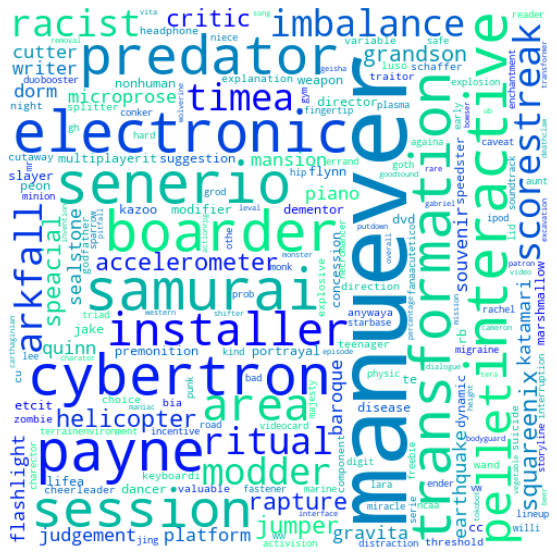

In [275]:
text = ' '.join(list(set(vocabulario_txt)))

wordcloud = WordCloud(background_color="white",
                      width=500, height=500,
                      colormap="winter",).generate(text)

plt.figure(figsize=(15,10))
p = plt.imshow(wordcloud, interpolation='bilinear')
p = plt.axis("off")

### Modelos

In [392]:
# Fazer o append com a acuracia dos modelos
acc_tdidf = {}
#acc_bow = []

In [305]:
def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
      principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='BrBG')
  plt.show()

In [369]:
def matriz_de_confusao(y_true, y_pred, modelo):
    plt.figure(figsize=(10,10))
    g = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='BrBG')
    g.set_title('Matriz de Confusão ' + modelo)
    g.set_xticklabels(['Falso', 'Positivo'])
    g.set_yticklabels(['Falso', 'Positivo'])
    g.set_xlabel('Modelo')
    g.set_ylabel('Teste')
    return g

In [226]:
dfReviewTest = pd.read_csv('video_games_reviews_test.csv')
dfReviewValid = pd.read_csv('video_games_reviews_dev.csv')

In [304]:
# Cria os vetores de treino e teste

X_train = X_tfidf
y_train = dfReview['overallBinary']

X_test = tfidf_vect.transform(dfReviewTest['reviewText'].replace(np.nan, ''))
y_test = dfReviewTest['overall'].apply(lambda x:1 if x > 3 else 0)

#### Arvores de decisao
[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [349]:
%%time
modelo_tree = DecisionTreeClassifier()
modelo_tree.fit(X_train, y_train)

CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 2.95 s


DecisionTreeClassifier()

In [350]:
y_pred_tree = modelo_tree.predict(X_test)

In [384]:
print(classification_report(y_test, y_pred_tree))

precision    recall  f1-score   support

           0       0.69      0.68      0.69      1512
           1       0.53      0.54      0.53       988

    accuracy                           0.63      2500
   macro avg       0.61      0.61      0.61      2500
weighted avg       0.63      0.63      0.63      2500

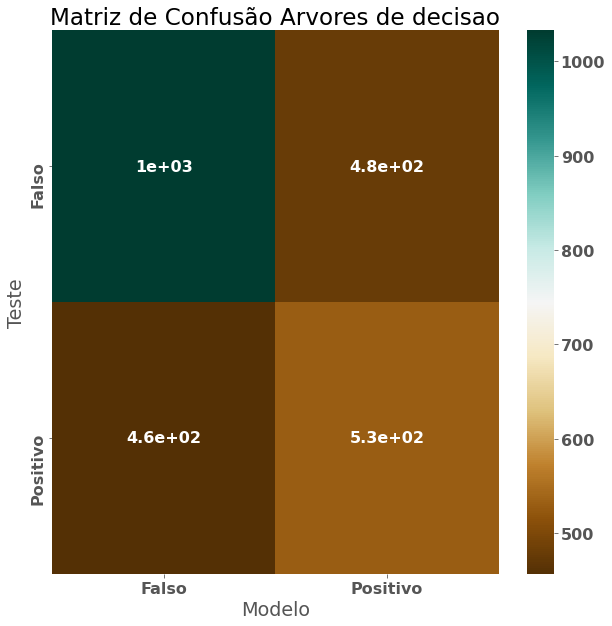

In [370]:
p = matriz_de_confusao(y_test, y_pred_tree, 'Arvores de decisao')

In [425]:
acc_tdidf['Arvores de decisao'] = f1_score(y_test, y_pred_tree, average='weighted')

#### Random Forest
[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [373]:
%%time
modelo_rf = RandomForestClassifier(n_estimators = 200)
modelo_rf.fit(X_train, y_train)

CPU times: user 17.2 s, sys: 0 ns, total: 17.2 s
Wall time: 17.2 s


RandomForestClassifier(n_estimators=200)

In [374]:
y_pred_rf = modelo_rf.predict(X_test)

In [385]:
print(classification_report(y_test, y_pred_rf))

precision    recall  f1-score   support

           0       0.74      0.90      0.81      1512
           1       0.77      0.51      0.61       988

    accuracy                           0.75      2500
   macro avg       0.76      0.70      0.71      2500
weighted avg       0.75      0.75      0.73      2500

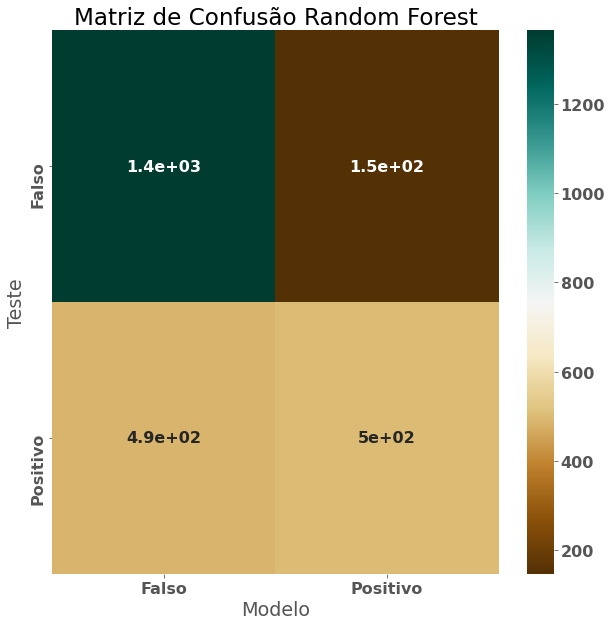

In [375]:
p = matriz_de_confusao(y_test, y_pred_rf, 'Random Forest')

In [426]:
acc_tdidf['Random Forest'] = f1_score(y_test, y_pred_rf, average='weighted')

#### Regressao Logistica
[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [309]:
%%time
modelo_reglog = LogisticRegression()
modelo_reglog.fit(X_train, y_train)

LogisticRegression()

In [313]:
y_pred_reglog = modelo_reglog.predict(X_test)

In [386]:
print(classification_report(y_test, y_pred_reglog))

precision    recall  f1-score   support

           0       0.80      0.84      0.82      1512
           1       0.74      0.68      0.71       988

    accuracy                           0.78      2500
   macro avg       0.77      0.76      0.76      2500
weighted avg       0.78      0.78      0.78      2500

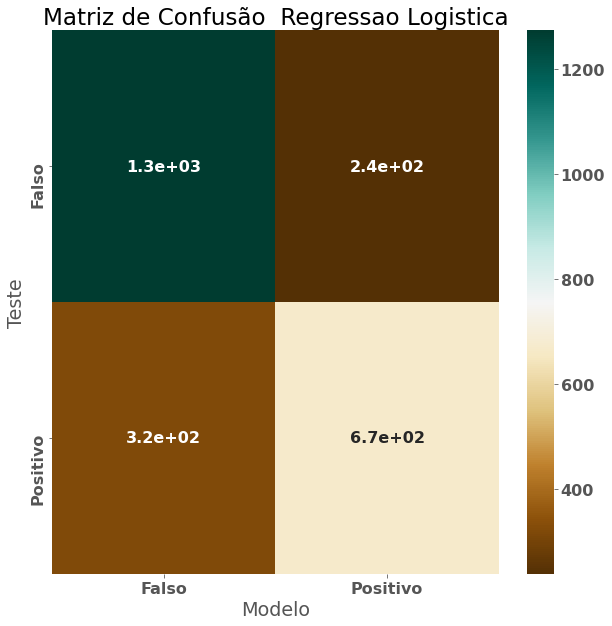

In [376]:
p = matriz_de_confusao(y_test, y_pred_reglog, ' Regressao Logistica')

In [427]:
acc_tdidf['Regressao Logistica'] = f1_score(y_test, y_pred_reglog, average='weighted')

#### Naive Bayes
[sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [417]:
%%time
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train.toarray(), y_train)

CPU times: user 1.05 s, sys: 573 ms, total: 1.63 s
Wall time: 1.27 s


MultinomialNB()

In [418]:
y_pred_nb = modelo_nb.predict(X_test.toarray())

In [419]:
print(classification_report(y_test, y_pred_nb))

precision    recall  f1-score   support

           0       0.62      1.00      0.77      1512
           1       0.93      0.08      0.14       988

    accuracy                           0.63      2500
   macro avg       0.78      0.54      0.46      2500
weighted avg       0.74      0.63      0.52      2500

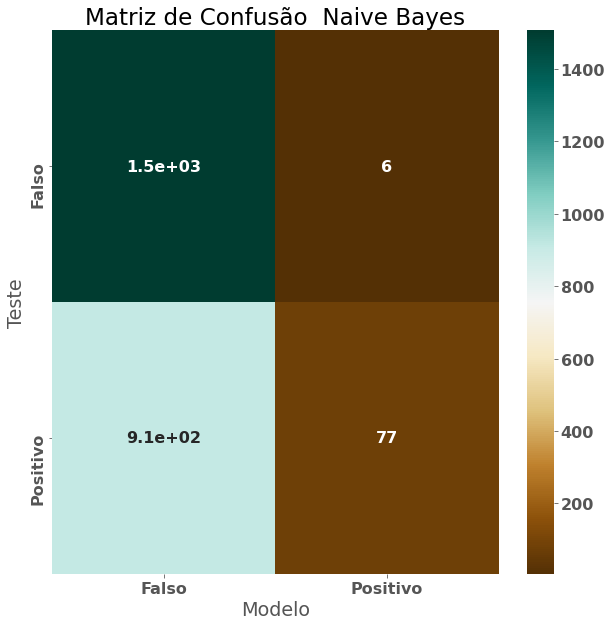

In [420]:
p = matriz_de_confusao(y_test, y_pred_nb, ' Naive Bayes')

In [428]:
acc_tdidf['Naive Bayes'] = f1_score(y_test, y_pred_nb, average='weighted')

#### SVM 
[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [378]:
%%time
modelo_svm = SVC()
modelo_svm.fit(X_train, y_train)

CPU times: user 26.3 s, sys: 79.7 ms, total: 26.4 s
Wall time: 26.4 s


SVC()

In [379]:
y_pred_svm = modelo_svm.predict(X_test)

In [389]:
print(classification_report(y_test, y_pred_svm))

precision    recall  f1-score   support

           0       0.80      0.84      0.82      1512
           1       0.73      0.67      0.70       988

    accuracy                           0.77      2500
   macro avg       0.76      0.75      0.76      2500
weighted avg       0.77      0.77      0.77      2500

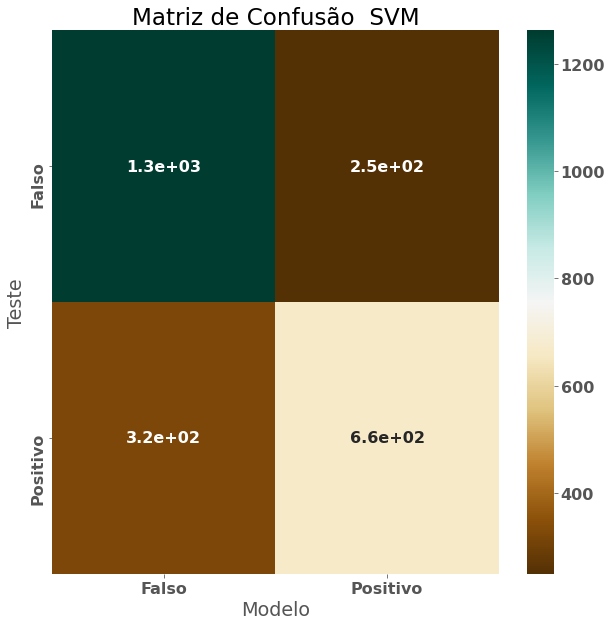

In [381]:
p = matriz_de_confusao(y_test, y_pred_svm, ' SVM')

In [429]:
acc_tdidf['SVM'] = f1_score(y_test, y_pred_svm, average='weighted')

### Comparacao do resultado dos modelos

/home/lhnds/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


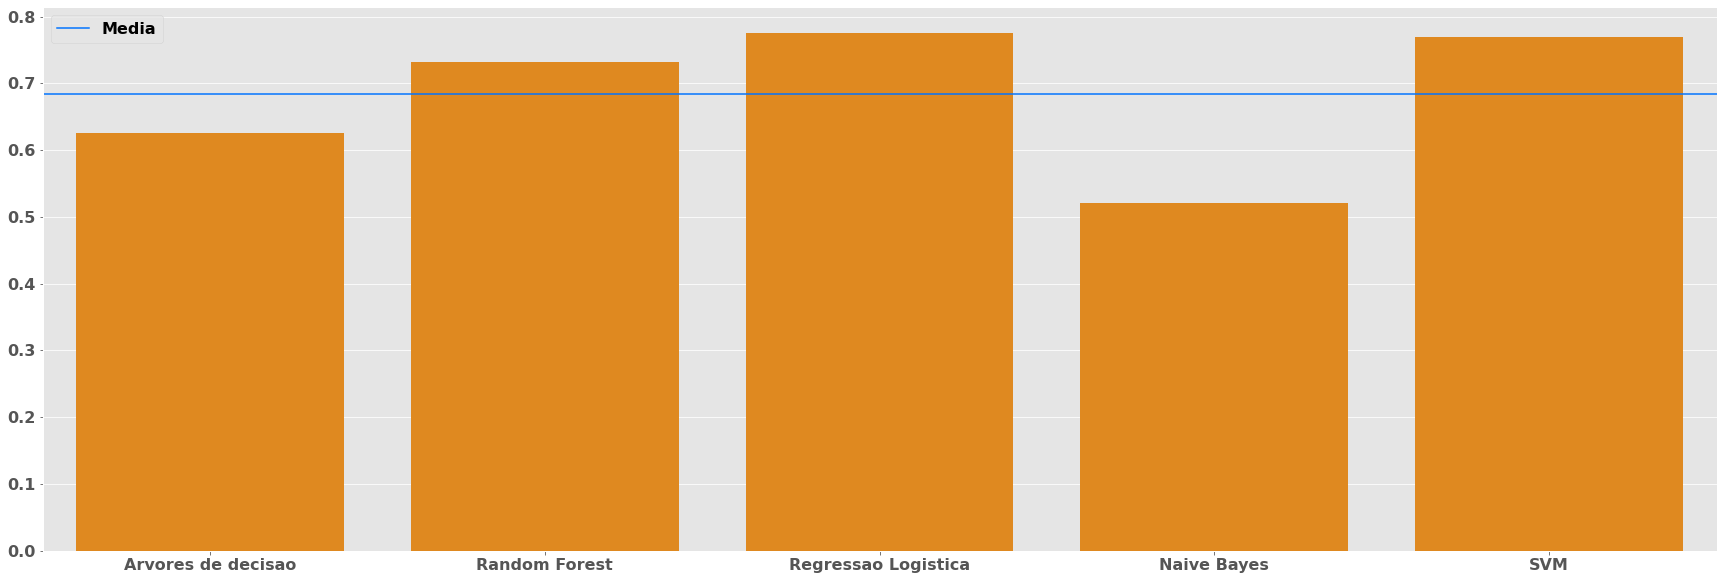

In [430]:
plt.figure(figsize=(30, 10))
g = sns.barplot(list(acc_tdidf.keys()), list(acc_tdidf.values()), color='#ff8c00')
p = g.axhline(np.mean(list(acc_tdidf.values())), color='#0073ff', label='Media')
g.legend()